In [59]:
import json

In [60]:
from NewsSentiment import TargetSentimentClassifier

class SentimentAnalyser:

    def __init__(self):
        self.tsc = TargetSentimentClassifier()
    
    def bounds_sentiment(self, mention_start, mention_end, sentence_start, sentence_end,
                         article_text, database_id):
        try:
            left_segment = article_text[sentence_start:mention_start]
            mention_segment = article_text[mention_start:mention_end]
            right_segment = article_text[mention_end:sentence_end]
    
    
            sentiment = self.tsc.infer_from_text(left_segment, mention_segment, right_segment)
            # print(sentiment[0])
    
            result = {
                "sentiment": sentiment[0],
                "left_segment": left_segment,
                "mention_segment": mention_segment,
                "right_segment": right_segment
            }
    
            return result
    
    
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            print(f"LEFT: {left_segment}")
            print(f"MENTION: {mention_segment}")
            print(f"RIGHT: {right_segment}")
    
            error_result = {
                "article_id": database_id,
                "bound_start": mention_start,
                "bound_end": mention_end,
                "left_segment": left_segment,
                "mention_segment": mention_segment,
                "right_segment": right_segment,
                "error_message": f"Exception during sentiment analysis: {str(e)}"
            }
    
            print(json.dumps(error_result))

        return None

In [61]:
def process_input_file(sentiment_analyzer, input_file_path, output_file_path):
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        total_lines = sum(1 for line in infile)  # For my progress tracking
        infile.seek(0)  # File pointer to beginning

        for line_number, line in enumerate(infile, start=1):
            data = json.loads(line)
            primary_gid = data["primary_gid"]
            sentence_normalized = data["sentence_normalized"]
            targets = data["targets"]

            for target in targets:
                mention_start = target["from"]
                mention_end = target["to"]
                mention = target["mention"]
                polarity = target["polarity"]

    
                result = sentiment_analyzer.bounds_sentiment(
                    mention_start, mention_end, 0, len(sentence_normalized),
                    sentence_normalized, primary_gid
                )

                target["result"] = result
                
                if polarity == 2.0:
                    polarity_string = "Negative"
                elif polarity == 4.0:
                    polarity_string = "Neutral"
                elif polarity == 6.0:
                    polarity_string = "Positive"
                else:
                    polarity_string = "POLARITY STRING ERROR"
                
                print(f"Processing line {line_number}/{total_lines}")
                print(mention)
                print(f"Mad TSC Polarity: {polarity_string}")
                print(f"News Sentiment: {result['sentiment']['class_label']}")

            outfile.write(json.dumps(data) + '\n')

In [62]:
sentiment_analyzer = SentimentAnalyser()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
input_file_path = "/Users/ameek/FY-Project/Notebook_Phase/MADTSC/Original_EN/test.jsonl"
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/MADTSC/News_Sentiment_Appended"
                    "/test_outpujson")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

This is providing exactly what I need really. Zero where we would expect and strong positives for 
duplicates!

In [64]:
input_file_path = "/Users/ameek/FY-Project/Notebook_Phase/MADTSC/Original_EN/validation.jsonl"
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/MADTSC/News_Sentiment_Appended"
                    "/validation_output.json")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

In [65]:
input_file_path = "/Users/ameek/FY-Project/Notebook_Phase/MADTSC/Original_EN/train.jsonl"
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/MADTSC/News_Sentiment_Appended"
                    "/train_output.json")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

In [7]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json",
]

results = []

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            json_line = json.loads(line)
            for target in json_line['targets']:
                true_label = target['polarity']
                predicted_label = target['result']['sentiment']['class_label']
                class_prob = target['result']['sentiment']['class_prob']
                processed_data.append({
                    'true_label': true_label,
                    'predicted_label': predicted_label
                })
    
    df = pd.DataFrame(processed_data)
    
    # Mad TSC datasets use 2,4,6 for negative, neutral and positive
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)
    
    accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    
    precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], average='weighted')
    
    conf_matrix = confusion_matrix(df['true_label'], df['predicted_label'])
    
    print(file_path)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)


/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json
Accuracy: 0.6637795275590551
Precision: 0.6758551457895594
Recall: 0.6637795275590551
F1-Score: 0.66506391088631
Confusion Matrix:
 [[966 235 162]
 [219 872 402]
 [ 94 169 691]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json
Accuracy: 0.667
Precision: 0.6877459546980731
Recall: 0.667
F1-Score: 0.6690318651450536
Confusion Matrix:
 [[264  51  49]
 [ 61 228 112]
 [ 22  38 175]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json
Accuracy: 0.6666666666666666
Precision: 0.6810831426392067
Recall: 0.6666666666666666
F1-Score: 0.6666078218255133
Confusion Matrix:
 [[86 15 11]
 [19 64 34]
 [10 11 50]]


In [24]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json",
]



results = []

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            json_line = json.loads(line)
            for target in json_line['targets']:
                true_label = target['polarity']
                predicted_label = target['result']['sentiment']['class_label']
                class_prob = target['result']['sentiment']['class_prob']
                
                processed_data.append({
                    'true_label': true_label,
                    'predicted_label': predicted_label
                })
    
    df = pd.DataFrame(processed_data)
    
    # Mad TSC datasets use 2,4,6 for negative, neutral and positive
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)
    

    
    accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    
    precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], labels=labels, average='weighted')
    
    conf_matrix = confusion_matrix(df['true_label'], df['predicted_label'], labels=labels)
    
    print(file_path)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)


/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json
Accuracy: 0.6637795275590551
Precision: 0.6758551457895594
Recall: 0.6637795275590551
F1-Score: 0.66506391088631
Confusion Matrix:
 [[966 235 162]
 [219 872 402]
 [ 94 169 691]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json
Accuracy: 0.667
Precision: 0.6877459546980731
Recall: 0.667
F1-Score: 0.6690318651450536
Confusion Matrix:
 [[264  51  49]
 [ 61 228 112]
 [ 22  38 175]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json
Accuracy: 0.6666666666666666
Precision: 0.6810831426392067
Recall: 0.6666666666666666
F1-Score: 0.6666078218255133
Confusion Matrix:
 [[86 15 11]
 [19 64 34]
 [10 11 50]]


In [20]:
import json
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json",
]


for threshold in [x * 0.1 for x in range(1, 10)]:
    print(f"\nThreshold: {threshold:.1f}")
    for file_path in file_paths:
        processed_data = []
        with open(file_path, 'r') as file:
            for line in file:
                json_line = json.loads(line)
                for target in json_line.get('targets', []):
                    true_label = target.get('polarity')
                    predicted_label = target.get('result', {}).get('sentiment', {}).get('class_label')
                    class_prob = target['result']['sentiment']['class_prob']

                    if class_prob >= threshold:
                        processed_data.append({
                            'true_label': true_label,
                            'predicted_label': predicted_label
                        })
        
        if processed_data:
            df = pd.DataFrame(processed_data)
            
            polarity_mapping = {
                2.0: 'negative',
                4.0: 'neutral',
                6.0: 'positive'
            }
            df['true_label'] = df['true_label'].map(polarity_mapping)
            

            precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], average='weighted')
            
            print(f"{file_path.split('/')[-1]} - F1-Score: {f1:.2f} | Total Results: {len(df)}")
        else:
            print(f"{file_path.split('/')[-1]} - No predictions met the threshold.")



Threshold: 0.1
train_output.json - F1-Score: 0.67 | Total Results: 3810
test_output.json - F1-Score: 0.67 | Total Results: 1000
validation_output.json - F1-Score: 0.67 | Total Results: 300

Threshold: 0.2
train_output.json - F1-Score: 0.67 | Total Results: 3810
test_output.json - F1-Score: 0.67 | Total Results: 1000
validation_output.json - F1-Score: 0.67 | Total Results: 300

Threshold: 0.3
train_output.json - F1-Score: 0.67 | Total Results: 3810
test_output.json - F1-Score: 0.67 | Total Results: 1000
validation_output.json - F1-Score: 0.67 | Total Results: 300

Threshold: 0.4
train_output.json - F1-Score: 0.67 | Total Results: 3797
test_output.json - F1-Score: 0.67 | Total Results: 997
validation_output.json - F1-Score: 0.67 | Total Results: 300

Threshold: 0.5
train_output.json - F1-Score: 0.68 | Total Results: 3606
test_output.json - F1-Score: 0.68 | Total Results: 934
validation_output.json - F1-Score: 0.69 | Total Results: 283

Threshold: 0.6
train_output.json - F1-Score: 0.72 |

Original Accuracy: 0.667
Original Precision: 0.6877459546980731
Original Recall: 0.667
Original F1-Score: 0.6690318651450536
Original Confusion Matrix:
 [[264  51  49]
 [ 61 228 112]
 [ 22  38 175]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json


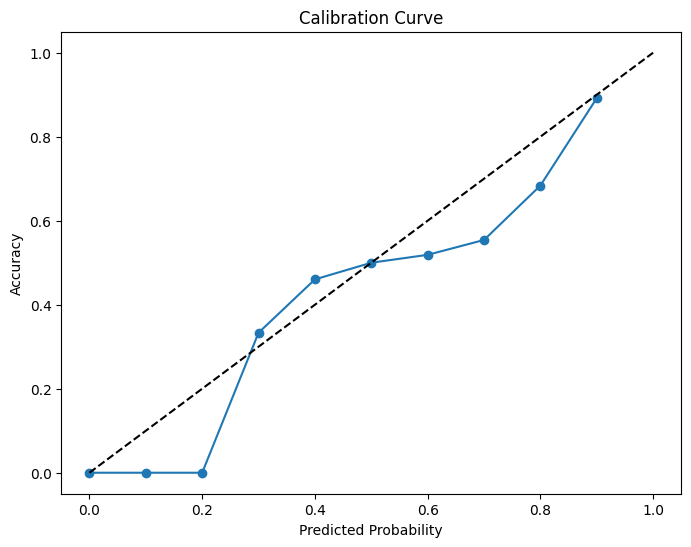

Number of items in each bin:
class_prob
9    314
8    196
7    157
5    134
6    133
4     63
3      3
Name: count, dtype: int64
Original Accuracy: 0.6637795275590551
Original Precision: 0.6758551457895594
Original Recall: 0.6637795275590551
Original F1-Score: 0.66506391088631
Original Confusion Matrix:
 [[966 235 162]
 [219 872 402]
 [ 94 169 691]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json


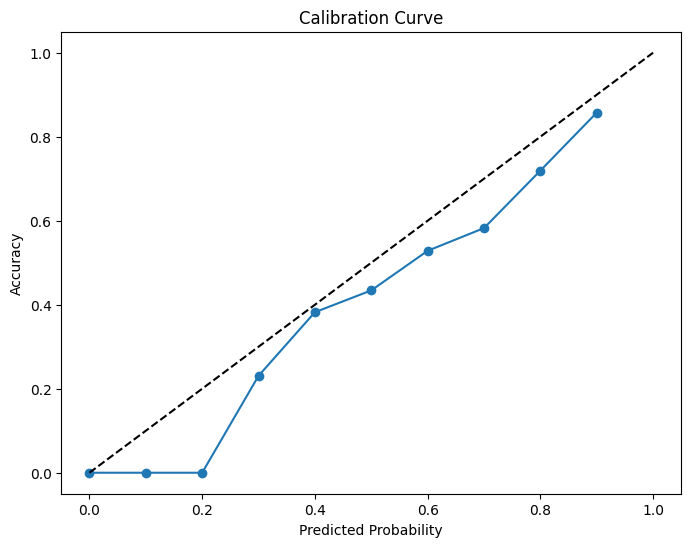

Number of items in each bin:
class_prob
9    1220
8     830
7     582
6     511
5     463
4     191
3      13
Name: count, dtype: int64
Original Accuracy: 0.6666666666666666
Original Precision: 0.6810831426392067
Original Recall: 0.6666666666666666
Original F1-Score: 0.6666078218255133
Original Confusion Matrix:
 [[86 15 11]
 [19 64 34]
 [10 11 50]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json


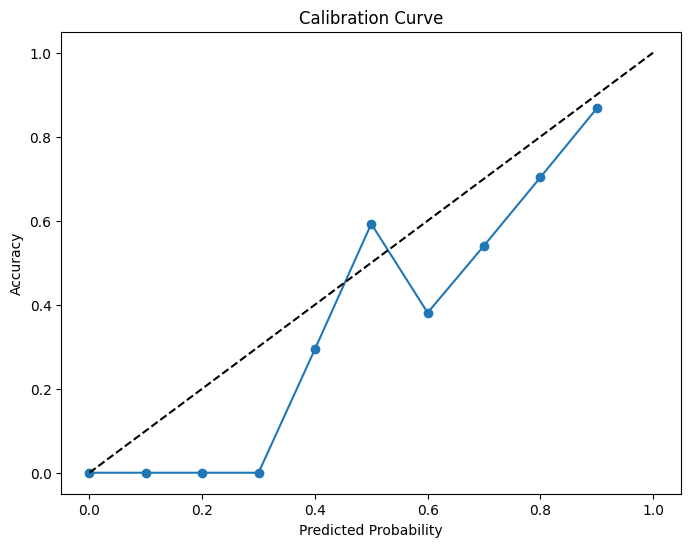

Number of items in each bin:
class_prob
9    113
8     64
6     42
7     37
5     27
4     17
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/validation_output.json",
]

# Threshold for class probability
threshold = 0.0

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        
        for line in file:
            json_line = json.loads(line)
            for target in json_line['targets']:
                true_label = target['polarity']
                predicted_label = target['result']['sentiment']['class_label']
                class_prob = target['result']['sentiment']['class_prob']
                # Apply threshold
                predicted_label_thresholded = predicted_label if class_prob > threshold else 'ignore'
                processed_data.append({
                    'true_label': true_label,
                    'predicted_label': predicted_label,
                    'class_prob': class_prob,
                    'predicted_label_thresholded': predicted_label_thresholded
                })
    
    df = pd.DataFrame(processed_data)
    
    # Mapping for polarity
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)

    accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], average='weighted')
    conf_matrix = confusion_matrix(df['true_label'], df['predicted_label'])
    
    # Print Original Results
    print("Original Accuracy:", accuracy)
    print("Original Precision:", precision)
    print("Original Recall:", recall)
    print("Original F1-Score:", f1)
    print("Original Confusion Matrix:\n", conf_matrix)

    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)

    # Bin/divide up the probabilities
    bins = pd.cut(df['class_prob'], bins=bin_edges, include_lowest=True, labels=False)
    
    # Calculating accuracy for each bin
    bin_accuracy = df.groupby(bins).apply(lambda x: accuracy_score(x['true_label'], x['predicted_label']) if not x.empty else 0)
    
    # Ensuring each bin has a value (fill missing bins with 0)
    bin_accuracy = bin_accuracy.reindex(range(n_bins), fill_value=0)
    
    print(file_path)
    plt.figure(figsize=(8, 6))
    plt.plot(bin_edges[:-1], bin_accuracy, marker='o')
    plt.plot([0, 1], [0, 1], 'k--') # Ideal line
    plt.xlabel('Predicted Probability')
    plt.ylabel('Accuracy')
    plt.title('Calibration Curve')
    plt.show()
    
    print("Number of items in each bin:")
    print(bins.value_counts())
    

In [2]:
import json

def get_polarity_string(polarity):
    mapping = {
        2.0: "Negative",
        4.0: "Neutral",
        6.0: "Positive"
    }
    return mapping.get(polarity, "POLARITY ERROR")

def count_polarities(file_path):
    polarity_counts = {"Positive": 0, "Negative": 0, "Neutral": 0}
    with open(file_path, 'r') as file:
        for line in file:
            json_line = json.loads(line)
            for target in json_line.get('targets', []):
                polarity = target.get('polarity')
                polarity_string = get_polarity_string(polarity)
                if polarity_string in polarity_counts:
                    polarity_counts[polarity_string] += 1
    return polarity_counts

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/validation_output.json",
]

for file_path in file_paths:
    counts = count_polarities(file_path)
    print(f"Polarity counts for {file_path}: {counts}")


Polarity counts for /Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json: {'Positive': 235, 'Negative': 364, 'Neutral': 401}
Polarity counts for /Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/train_output.json: {'Positive': 954, 'Negative': 1363, 'Neutral': 1493}
Polarity counts for /Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/validation_output.json: {'Positive': 71, 'Negative': 112, 'Neutral': 117}


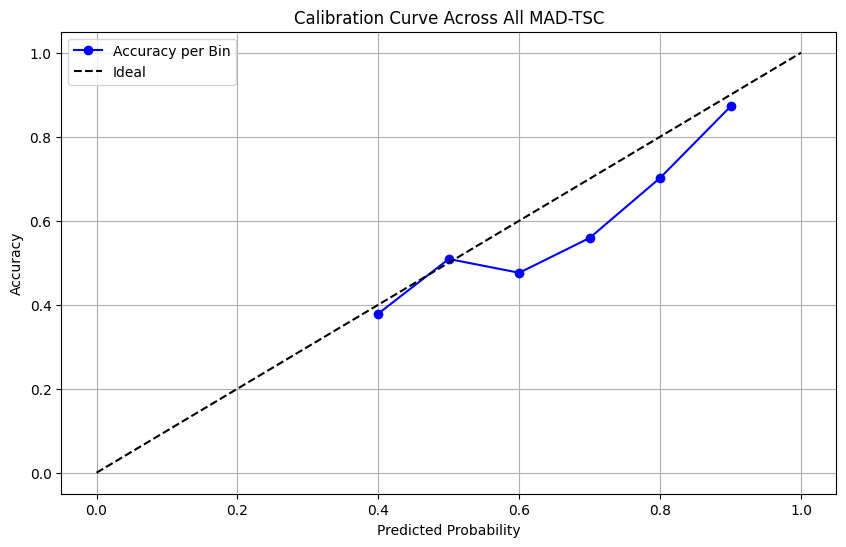

In [28]:
# Single Graph

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC/News_Sentiment_Appended/test_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/MADTSC"
    "/News_Sentiment_Appended/validation_output.json",
]

threshold = 0.00
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_accuracy_total = pd.Series(0, index=np.arange(n_bins))

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            json_line = json.loads(line)
            for target in json_line['targets']:
                true_label = target['polarity']
                predicted_label = target['result']['sentiment']['class_label']
                class_prob = target['result']['sentiment']['class_prob']
                # Apply threshold
                predicted_label_thresholded = predicted_label if class_prob > threshold else 'ignore'
                processed_data.append({
                    'true_label': true_label,
                    'predicted_label': predicted_label,
                    'class_prob': class_prob,
                    'predicted_label_thresholded': predicted_label_thresholded
                })
    
    df = pd.DataFrame(processed_data)
    
    # Mapping for polarity
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)

    # Bin/divide up the probabilities
    bins = pd.cut(df['class_prob'], bins=bin_edges, include_lowest=True, labels=False)
    
    # Calculating accuracy for each bin
    bin_accuracy = df.groupby(bins).apply(lambda x: accuracy_score(x['true_label'], x['predicted_label']) if not x.empty else np.nan)
    
    # Aggregating bin accuracies across files
    bin_accuracy_total += bin_accuracy.fillna(0)

# Average the accuracy by the number of files
bin_accuracy_avg = bin_accuracy_total / len(file_paths)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], bin_accuracy_avg, marker='o', linestyle='-', color='blue', label='Accuracy per Bin')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')  # Ideal line
plt.xlabel('Predicted Probability')
plt.ylabel('Accuracy')
plt.title('Calibration Curve Across All MAD-TSC')
plt.legend()
plt.grid(True)
plt.show()